In [1]:
# Getting packages
from os import sys
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.io

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

plt.style.use('../basic_plotter.mplstyle')

In [2]:
# Importing data
df_ls = main.get_data("Alton", "/linus-2023-05-26/00000003.BIN", "10ms")
df_ls = df_ls.interpolate(method="linear")

df_hs = main.get_data("Alton", "/linus-2023-05-26/00000004.BIN", "10ms")
df_hs = df_hs.interpolate(method="linear")

Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: AP433Dataflash
ArdupilotDFReader - INFO     - Begin processing /Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/data//linus-2023-05-26/00000003.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=1
ArdupilotDFReader - INFO     - 2023-05-27 02:24:41.200000 at board time = 1970-01-01 00:04:43.837190
Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: AP433Dataflash
ArdupilotDFReader - INFO     - Begin processing /Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/data//linus-2023-05-26/00000004.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=1
ArdupilotDFReader - INFO     - 2023-05-27 02:48:08.200000 at board time = 1970-01-01 00:01:59.421842


In [3]:
# Defining vehicle
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 1.563 + 0.230 # Estimated with virtual bolt included
span = 2.54
chord = 0.149
linus = airplane(mass, chord, span)

P_systems = 0.3 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

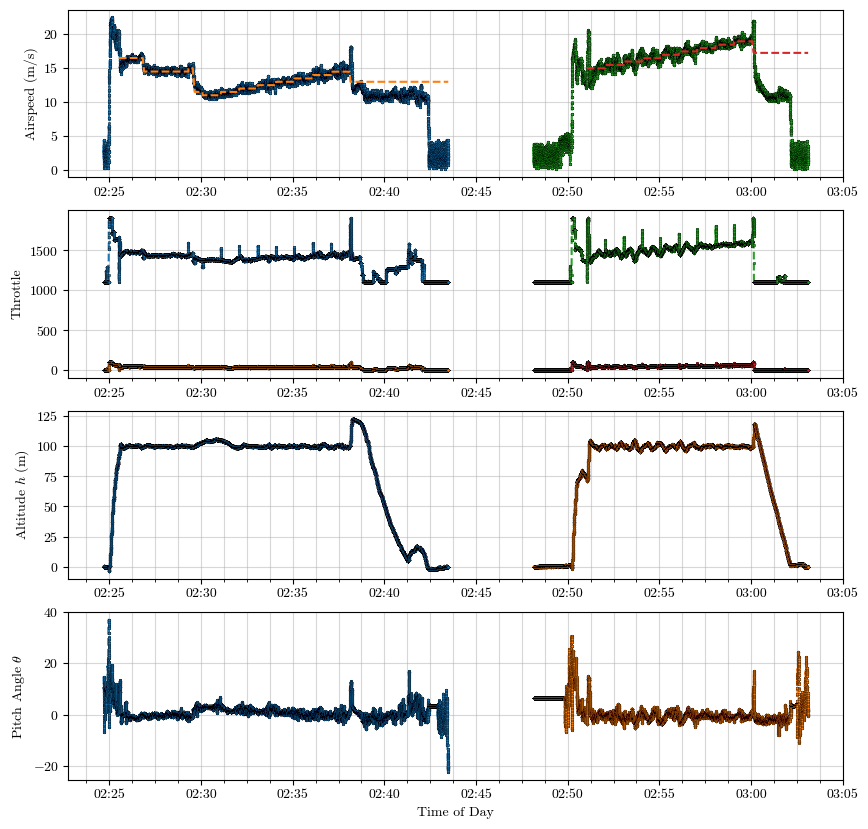

In [4]:
# Creating plots to segment data

plt.figure(figsize=(10,10))
ax0 = plt.subplot(4,1,1)
# plt.grid(which='major', linestyle='-')
# plt.grid(which='minor', linestyle=':', color='grey')
plt.plot(df_ls.index, df_ls.Airspeed_Sensor0, linestyle='--',label="Airspeed sensor (EAS)")
plt.plot(df_ls.index, df_ls.Airspeed_Demanded, linestyle='--',marker='', label="Demanded Airspeed (EAS)")
plt.plot(df_hs.index, df_hs.Airspeed_Sensor0, linestyle='--')
plt.plot(df_hs.index, df_hs.Airspeed_Demanded, linestyle='--',marker='')

plt.ylabel("Airspeed (m/s)")
ax1 = plt.subplot(4,1,2, sharex=ax0)
plt.plot(df_ls.index, df_ls.ThrottleOut, linestyle='--', label='Throttle PWM Output')
plt.plot(df_ls.index, df_ls.Throttle, linestyle='--', label='Throttle Percent')
plt.plot(df_hs.index, df_hs.ThrottleOut, linestyle='--')
plt.plot(df_hs.index, df_hs.Throttle, linestyle='--')
plt.ylabel("Throttle")
ax2 = plt.subplot(4,1,3, sharex=ax0)
plt.plot(df_ls.index, df_ls.Altitude_BARO_0, linestyle='--')
plt.plot(df_hs.index, df_hs.Altitude_BARO_0, linestyle='--')
plt.ylabel("Altitude $h$ (m)")
ax3 = plt.subplot(4,1,4, sharex=ax0)
plt.plot(df_ls.index, df_ls.PitchAngle, linestyle='--')
plt.plot(df_hs.index, df_hs.PitchAngle, linestyle='--')
plt.ylabel("Pitch Angle $\\theta$ ")
plt.xlabel('Time of Day')
plt.show()

In [27]:
# Main Analysis (Low Speed)

# Attitude 
phi = np.deg2rad(df_ls["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df_ls["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df_ls["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df_ls["Pressure_BARO0"].to_numpy() * (287 * (df_ls["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas_ls = df_ls["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas_ls * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df_ls["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df_ls["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df_ls["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df_ls["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df_ls["MainBatteryCurrent"].to_numpy()
v_esc = df_ls["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_ct_ls = cl_finders.thrust_steady(prop, rho, v_tas, n)

# Getting drag coefficient
Cd_ct_ls = cl_finders.preq2cd(linus, v_tas, q, P_ct_ls)

# Getting lift coefficient
CL_ls = cl_finders.cl_banked(linus, q, phi)

In [28]:
# Main Analysis (High Speed)

# Attitude 
phi = np.deg2rad(df_hs["RollAngle"].to_numpy())            # Bank angle in radians
pitch = np.deg2rad(df_hs["PitchAngle"].to_numpy())         # Pitch angle in radians

# Inertial Measurement Unit
U_dot = df_hs["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction

# Atmospheric adjustments:
rho = df_hs["Pressure_BARO0"].to_numpy() * (287 * (df_hs["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas_hs = df_hs["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas_hs * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df_hs["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df_hs["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df_hs["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df_hs["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df_hs["MainBatteryCurrent"].to_numpy()
v_esc = df_hs["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_ct_hs = cl_finders.thrust_steady(prop, rho, v_tas, n)
# Getting drag coefficient
Cd_ct_hs = cl_finders.preq2cd(linus, v_tas, q, P_ct_hs)
# Getting lift coefficient
CL_hs = cl_finders.cl_banked(linus, q, phi)

In [29]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing masks for dataframe

def get_mask(df, start, end, year, month, day):
    # Getting boolean mask from start and end times
    start_time = get_datetime(start, year, month, day)
    end_time = get_datetime(end, year, month, day)
    mask = (df.index > start_time) & (df.index < end_time)
    return mask

def get_datetime(hour_string, year, month, day):
    # Results completed datetime from hour string, and date
    split_nums = hour_string.split(':')
    hours = int(split_nums[0])
    minutes = int(split_nums[1])
    seconds = int(split_nums[2])
    return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

# Cruise Masking
ls_segtimes = np.array([['02:29:40','02:30:04'],
                      ['02:30:06','02:31:04'],
                      ['02:31:05','02:32:04'],
                      ['02:32:06','02:33:04'],
                      ['02:33:06','02:34:05'],
                      ['02:34:06','02:35:05'],
                      ['02:35:06','02:36:05'],
                      ['02:36:07','02:37:05'],
                      ['02:37:07','02:38:06']])
hs_segtimes = np.array([['02:51:30','02:52:02'],
                      ['02:52:04','02:53:02'],
                      ['02:53:04','02:54:02'],
                      ['02:54:04','02:55:03'],
                      ['02:55:04','02:56:03'],
                      ['02:56:04','02:57:03'],
                      ['02:57:05','02:58:03'],
                      ['02:58:05','02:59:03'],
                      ['02:59:05','03:00:04']])
masks_ls = []
for i in range(np.shape(ls_segtimes)[0]):
    mask = get_mask(df_ls, ls_segtimes[i,0], ls_segtimes[i,1], 2023, 5, 27)
    masks_ls.append(mask)

masks_hs = []
for i in range(np.shape(hs_segtimes)[0]):
    mask = get_mask(df_hs, hs_segtimes[i,0], hs_segtimes[i,1], 2023, 5, 27)
    masks_hs.append(mask)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 89874 but corresponding boolean dimension is 112802

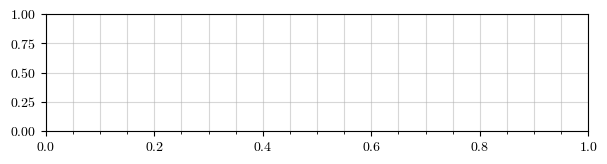

In [15]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 0.01
markedgew = 0.1
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, h[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, P_ct[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, P_eta[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

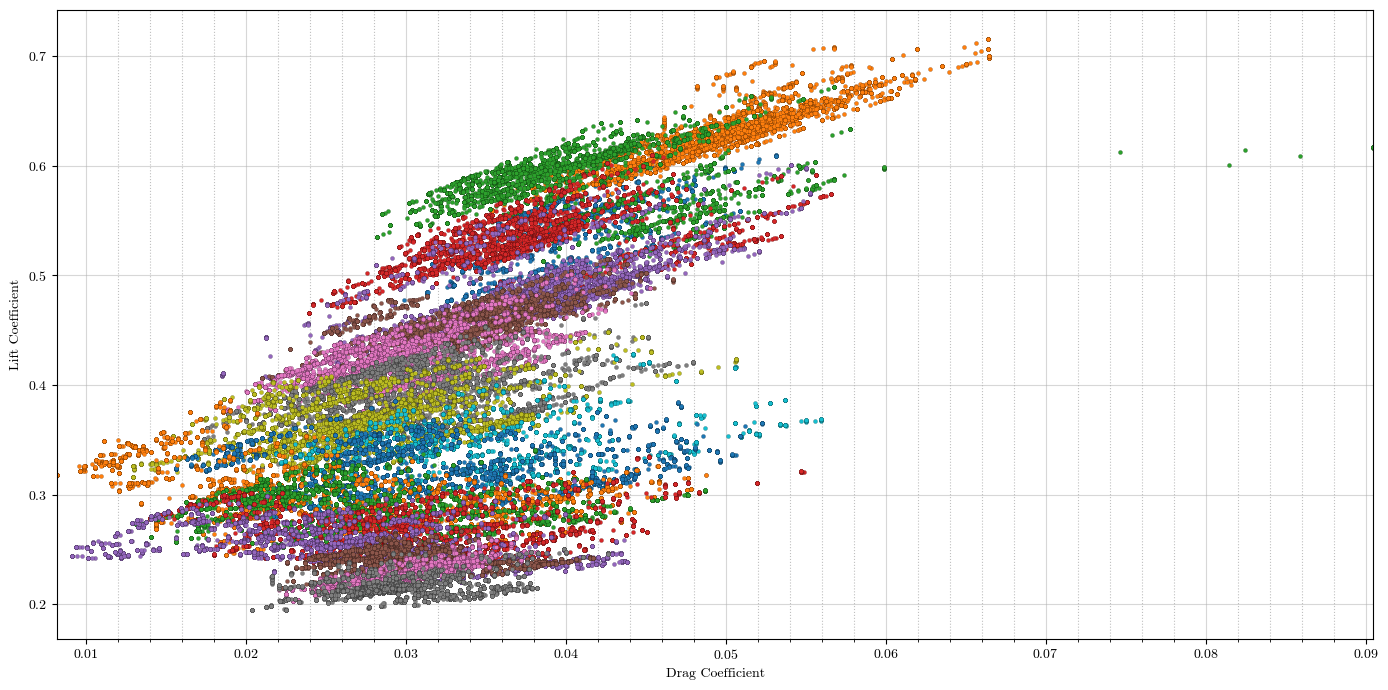

In [30]:
# Plotting the drag polar of the Vehicle

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,1,1)
for i in range(len(masks_ls)):
    ax1.plot(Cd_ct_ls[masks_ls[i]], CL_ls[masks_ls[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
for i in range(len(masks_hs)):
    ax1.plot(Cd_ct_hs[masks_hs[i]], CL_hs[masks_hs[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')

ax1.set_ylabel("Lift Coefficient")
ax1.set_xlabel("Drag Coefficient")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

In [39]:
def process_segments(CL, CD, v_eas, masks):
    # Inputs:
    # 1. Estimated coefficient of lift array (whole dataset)
    # 2. Estimated coefficient of drag array (whole dataset)
    # 3. Masks dividing up the dataset into segments that need to be processed
    # Outputs:
    # 1. Averaged segment CL, CD
    # 2. Standard deviation 
    # Initializing empty arrays to place segment results
    CL_ave = np.zeros(len(masks))
    CD_ave = np.zeros(len(masks))
    EAS_ave = np.zeros(len(masks))

    CL_std = np.zeros(len(masks))
    CD_std = np.zeros(len(masks))
    EAS_std = np.zeros(len(masks))

    CD_95 = np.zeros(len(masks))
    CL_95 = np.zeros(len(masks))
    EAS_95 = np.zeros(len(masks))

    # Iterating through all segments, averaging, stding
    for i in range(len(masks)):
    
        CD_ave[i] = np.mean(CD[masks[i]])
        CL_ave[i] = np.mean(CL[masks[i]])
        EAS_ave[i] = np.mean(v_eas[masks[i]])
    
        CD_std[i] = np.std(CD[masks[i]])
        CL_std[i] = np.std(CL[masks[i]])
        EAS_std[i] = np.std(v_eas[masks[i]])

        # Finding 95% Confidence Interval
        CD_95[i] = 1.96 * CD_std[i] * (np.sqrt(len(CD[masks[i]])) **-1)
        CL_95[i] = 1.96 * CL_std[i] * (np.sqrt(len(CL[masks[i]])) **-1)
        EAS_95[i] = 1.96 * EAS_std[i] * (np.sqrt(len(v_eas[masks[i]])) **-1)
    return CL_ave, CD_ave, EAS_ave, CL_95, CD_95, EAS_95

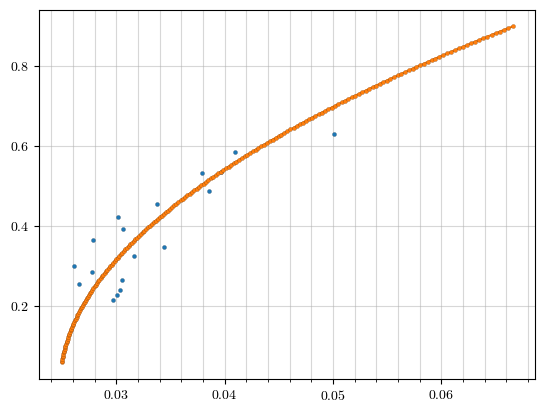

In [40]:
# Loitering mask (LS)

CL_ave, CD_ave, EAS_ave, CL_95, CD_95, EAS_95 = process_segments(CL_ls, Cd_ct_ls,v_eas_ls, masks_ls)
CL_ave_1, CD_ave_1, EAS_ave_1, CL_95_1, CD_95_1, EAS_95_1 = process_segments(CL_hs, Cd_ct_hs, v_eas_hs, masks_hs)

CL_ave = np.concatenate((CL_ave, CL_ave_1))
CD_ave = np.concatenate((CD_ave, CD_ave_1))
EAS_ave = np.concatenate((EAS_ave, EAS_ave_1))
CL_95 = np.concatenate((CL_95, CL_95_1))
CD_95 = np.concatenate((CD_95, CD_95_1))
EAS_95 = np.concatenate((EAS_95, EAS_95_1))

# Finding drag polar:
polar_ct = cl_finders.cd2polar(linus, CD_ave, CL_ave, highorder=False)
#polar_ct = [0.025, 1]
# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_ct, EAS = cl_finders.polar2preqew(linus, polar_ct, (8,28), createvstandardweight=False)

CL_fitted, CD_fitted = cl_finders.plotfittedpolar(linus, polar_ct, np.array([0.06, 0.9]))

plt.figure()
plt.plot(CD_ave, CL_ave, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
plt.plot(CD_fitted, CL_fitted, marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='-')
plt.show()

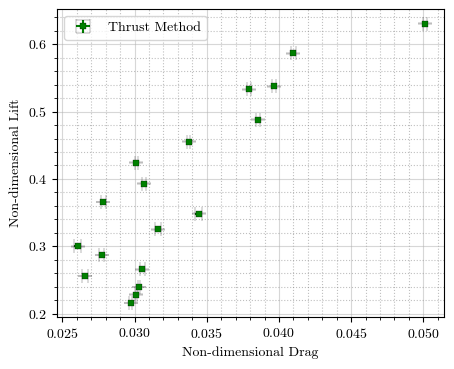

In [46]:
# Drag Polar plots #

# 95% Confidence Interval!
plt.figure(figsize=(5,4))
plt.errorbar(CD_ave, CL_ave, xerr=CD_95, yerr=CL_95, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])
plt.xlabel("Non-dimensional Drag")
plt.ylabel("Non-dimensional Lift")
plt.legend()
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_89033/4084112041.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,4))


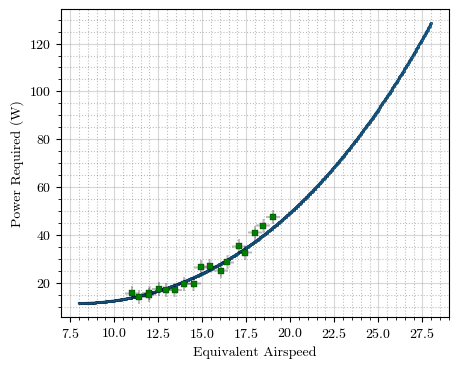

In [45]:
# Drag Polar plots #

plt.figure(figsize=(5,4))
plt.plot(EAS, Peq_ct, label="Thrust Method", markeredgecolor=[0,0,0])
plt.errorbar(EAS_ave, CD_ave * 0.5 * 1.225 * EAS_ave**3 * linus.area, xerr=EAS_95, yerr=CD_95* 0.5 * 1.225 * EAS_ave**3 * linus.area, capsize=5, fmt='sg', label="Thrust Method", markeredgecolor=[0,0,0])

plt.xlabel("Equivalent Airspeed")
plt.ylabel("Power Required (W)")
plt.grid(True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout
plt.show()